<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/NEWNEW_MIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')



df = df[df['n/m']==2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] #cple
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [2]:
y_new = []
cnt0=0
cnt1=0
cnt2=0
cnt3=0
for val in y:
  if(val<10):
    y_new.append(0)
    cnt0+=1
  elif(10 <= val and val<1000):
    y_new.append(1)
    cnt1+=1
  else:
    y_new.append(2)
    cnt2+=1

cnt = 0
if(cnt0>0):
  cnt+=1
if(cnt1>0):
  cnt+=1
if(cnt2>0):
  cnt+=1
if(cnt3>0):
  cnt+=1

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)

In [3]:
names = [ 'av.length', 'n', 'std.dev', 'k', 'm', 'max']
X_modified = X.drop([   'n/m', 'indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','median', 'min', 'range'], axis = 1)
print(X_modified.head())
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(random_state=0)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)


     n    m   av.length     std.dev  max    k          y
0  180   90   74.783333   14.444373  100   51  15.495687
1  120   60   47.241665   27.169245   99   70   1.217628
2  180   90  455.455566  161.580276  719  150   6.639741
3  140   70  574.464294  134.110840  894  117   3.155640
4  200  100   63.680000   24.820713  100   75  28.157019


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.83)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y', 'k', 'm'], axis = 1)

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y', 'k', 'm'], axis = 1)
X_test = sc.transform(X_test)

1267
260
        n   m   av.length     std.dev   max    k             y
1362  180  90  706.877808  175.294418  1104  154  99999.000000
511    80  40   52.587502   26.850121   100   56     11.129904
9     120  60  301.091675  102.802505   480  107      3.469282
393    40  20  102.425003   22.303143   160   31      0.654424
471   140  70  569.014282  133.063202   914  127      2.286228


In [6]:

from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(8, input_dim = X_modified.shape[1]-3, activation='relu'))

classifier.add(Dense(12, activation = 'relu'))
classifier.add(Dropout(0.125))

#classifier.add(Dense(32, activation = 'relu'))

#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(16, activation = 'relu'))

#classifier.add(Dense(16, activation='relu'))

#classifier.add(Dense(8, activation='relu'))

#classifier.add(Dense(12, activation='relu'))

classifier.add(Dense(cnt, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 12)                108       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 39        
                                                                 
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 64, 
                    epochs = 350, shuffle = True)

Epoch 1/350
20/20 [==============================] - 1s 5ms/step - loss: 1.1259 - accuracy: 0.3386
Epoch 2/350
20/20 [==============================] - 0s 4ms/step - loss: 1.0561 - accuracy: 0.3662
Epoch 3/350
20/20 [==============================] - 0s 2ms/step - loss: 0.9976 - accuracy: 0.4507
Epoch 4/350
20/20 [==============================] - 0s 4ms/step - loss: 0.9542 - accuracy: 0.5343
Epoch 5/350
20/20 [==============================] - 0s 5ms/step - loss: 0.9118 - accuracy: 0.5746
Epoch 6/350
20/20 [==============================] - 0s 4ms/step - loss: 0.8778 - accuracy: 0.5975
Epoch 7/350
20/20 [==============================] - 0s 4ms/step - loss: 0.8392 - accuracy: 0.6172
Epoch 8/350
20/20 [==============================] - 0s 4ms/step - loss: 0.8083 - accuracy: 0.6409
Epoch 9/350
20/20 [==============================] - 0s 5ms/step - loss: 0.7749 - accuracy: 0.6488
Epoch 10/350
20/20 [==============================] - 0s 4ms/step - loss: 0.7359 - accuracy: 0.6875
Epoch 11/

accuracy: 90.38%


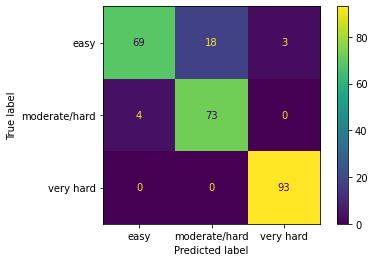

In [8]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])
cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [9]:
column_names = ['n', 'k', 'n/m', 'av.length', 'std.dev', 'y']
df_reg = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': 2, 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)
#VM

260
260


In [10]:
column_names = ['n', 'k', 'm', 'std.dev', 'y']
df_reg0 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'max': X_test_copy.iloc[i]['max'],
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

260
260


In [11]:
column_names = ['n', 'k', 'av.length', 'std.dev', 'm', 'y']
df_reg2 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'm': X_test_copy.iloc[i]['m'],
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

260
260


In [12]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')




df = df[df['n/m']!=2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] 
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [13]:
y_new = []
for val in y:
  if(val<10):
    y_new.append(0)
  elif(10 <= val and val <1000):
    y_new.append(1)
  else:
    y_new.append(2)

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)
X_modified = X

In [14]:
from imblearn.over_sampling import RandomOverSampler

names =[ 'std.dev', 'n','n/m', 'max','av.length', 'm', 'k']
X_modified = X.drop([  'median', 'range',  'min','indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n'], axis = 1)
X_modified['n/m'] = X_modified['n/m']
#print(X_modified.head())

oversample = RandomOverSampler(random_state=0)
#oversample.fit(X_modified, y_encoded)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [16]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.83)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y',  'm'], axis = 1)
X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y',  'm'], axis = 1)
X_test = sc.transform(X_test)

11401
2336
         n   m   n/m   av.length     std.dev  max    k             y
3234   160  40  4.00   53.724998   29.127333  100   78     40.832211
4495   198  72  2.75  508.691925  167.474625  790  172  99999.000000
10982   36  16  2.25   52.750000   24.797897   97   32      1.885425
9657    18   8  2.25   74.722221   16.876038  101   16      0.093937
5976   162  54  3.00   46.740742   28.289444  100   76     41.455616


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(16, input_dim = X_modified.shape[1]-2, activation='relu'))

classifier.add(Dropout(0.2))

classifier.add(Dense(3, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                112       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 32, 
                    epochs = 120)

Epoch 1/120
357/357 [==============================] - 1s 2ms/step - loss: 0.7257 - accuracy: 0.6885
Epoch 2/120
357/357 [==============================] - 1s 2ms/step - loss: 0.4566 - accuracy: 0.8214
Epoch 3/120
357/357 [==============================] - 1s 2ms/step - loss: 0.4088 - accuracy: 0.8414
Epoch 4/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3889 - accuracy: 0.8469
Epoch 5/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3691 - accuracy: 0.8519
Epoch 6/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.8618
Epoch 7/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3525 - accuracy: 0.8613
Epoch 8/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3413 - accuracy: 0.8653
Epoch 9/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3447 - accuracy: 0.8650
Epoch 10/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3382 - accura

accuracy: 91.18%


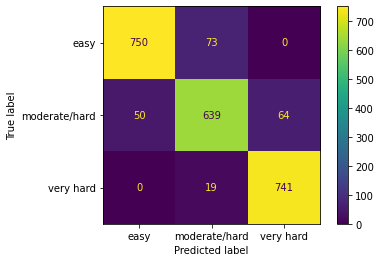

In [19]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])

cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [20]:
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': X_test_copy.iloc[i]['n/m'], 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)

for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'max': X_test_copy.iloc[i]['max'],
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'm': X_test_copy.iloc[i]['m'],
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

In [21]:
print(df_reg.shape[0])
print(df_reg.head(500))

822
         n      k    n/m   av.length     std.dev          y
0    180.0   75.0   2.00   59.994446   23.497177  22.163019
1    160.0   49.0   2.00   73.662498   14.831930  10.595284
2    120.0   68.0   2.00   51.858334   29.652130  14.296589
3    200.0   86.0   2.00   47.115002   30.439852   2.294968
4    200.0  170.0   2.00  477.850006  163.834488  65.560165
..     ...    ...    ...         ...         ...        ...
495  162.0  108.0   2.25  104.382713   49.349834   4.153656
496  140.0   60.0   5.00   99.935715   19.174026  49.476032
497  144.0   97.0   2.25  103.076385   54.047779   3.564702
498  100.0   65.0  10.00   47.400002   28.686743   9.583375
499  180.0   81.0   2.50   96.805557   21.808741  51.911041

[500 rows x 6 columns]


In [22]:
print(df_reg0.head())

       n      k     m     std.dev          y     max
0   80.0   56.0  40.0   26.850121  11.129904   100.0
1   40.0   31.0  20.0   22.303143   0.654424   160.0
2  140.0  127.0  70.0  133.063202   2.286228   914.0
3   80.0   39.0  40.0   15.746810   2.160869   100.0
4  180.0  159.0  90.0  185.726913   6.023255  1266.0


In [23]:
print(df_reg2.head())

       n      k   av.length     std.dev     m             y
0  180.0  154.0  706.877808  175.294418  90.0  99999.000000
1  120.0  107.0  301.091675  102.802505  60.0      3.469282
2   80.0   66.0  106.937500   48.509495  40.0  99999.000000
3  140.0  121.0  547.578552  137.977631  70.0  99999.000000
4  120.0  100.0  319.049988  109.162712  60.0  99999.000000


In [24]:
for i in range(df_reg.shape[0]):
  if(df_reg.iloc[i]['y'] >1000):
    df_reg.loc[i, 'y'] = 1001

for i in range(df_reg0.shape[0]):
  if(df_reg0.iloc[i]['y'] > 10):
    df_reg0.loc[i, 'y'] = 11

for i in range(df_reg2.shape[0]):
  if(df_reg2.iloc[i]['y'] == 99999):
    df_reg2.loc[i, 'y'] = 4510


print(df_reg['y'].max())
shuffled = df_reg.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

1001.0


In [25]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
tmp = tmp.sample(frac = 1).reset_index()
print(tmp.head(60))
#y = np.log10(tmp['y']*10)+20
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

6312
6312
    index      n      k    n/m   av.length     std.dev    y
0    1783  180.0  109.0   3.00  103.933334   49.045372   60
1    3237  108.0   56.0   9.00   61.462963   24.649858  134
2    6137   80.0   40.0  10.00   73.574997   14.510385  751
3    5728  162.0   70.0   6.00   58.728394   22.805967  491
4    3045  120.0   71.0   5.00   47.933334   29.299019  123
5    5363   90.0   56.0   6.00   96.633331   21.565914  357
6    2655  200.0   88.0   5.00   50.060001   30.199945  105
7    1472  162.0   66.0   2.25  101.012344   18.443462   44
8    4748  140.0  119.0   2.50  332.799988  112.981964  273
9    3924   60.0   49.0   5.00  147.333328   55.840767  187
10   2758  144.0   71.0   4.50  101.243057   20.468037  110
11   5520  110.0   95.0   2.75  440.518188  114.116776  411
12   4909  160.0   47.0   5.00   74.793747   15.111367  289
13   1325   80.0   68.0   2.50  322.787506   81.723465   35
14   4508   40.0   38.0  10.00  159.175003   37.038364  247
15   3130  180.0   65.0   4.50

In [26]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer="Adam")
    return model

In [27]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


82/82 [==============================] - 1s 2ms/step - loss: 2741741.5000
Epoch 2/300
82/82 [==============================] - 0s 2ms/step - loss: 510046.1875
Epoch 3/300
82/82 [==============================] - 0s 2ms/step - loss: 109634.3828
Epoch 4/300
82/82 [==============================] - 0s 2ms/step - loss: 63492.0703
Epoch 5/300
82/82 [==============================] - 0s 2ms/step - loss: 50142.3867
Epoch 6/300
82/82 [==============================] - 0s 2ms/step - loss: 41937.9883
Epoch 7/300
82/82 [==============================] - 0s 2ms/step - loss: 35728.5859
Epoch 8/300
82/82 [==============================] - 0s 2ms/step - loss: 31357.5312
Epoch 9/300
82/82 [==============================] - 0s 2ms/step - loss: 27757.1777
Epoch 10/300
82/82 [==============================] - 0s 2ms/step - loss: 25303.9902
Epoch 11/300
82/82 [==============================] - 0s 2ms/step - loss: 23037.7266
Epoch 12/300
82/82 [==============================] - 0s 2ms/step - loss: 21790.19

In [28]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

17/17 [==============================] - 0s 1ms/step
r_square score:  0.877120485170245
RMSE:


65.69904119564477

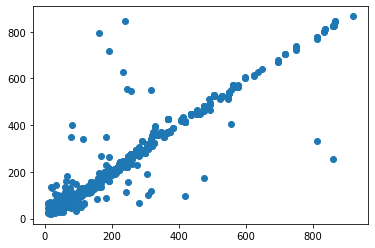

In [29]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>=10 and yy[i]<1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)

In [30]:
shuffled = df_reg0.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [31]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

3542
3542
       n     k     m    std.dev    max   y
0   36.0  29.0   8.0  37.736965  212.0  11
1   18.0  16.0   8.0  59.945076  216.0   0
2   36.0  31.0  12.0  33.475353  223.0   1
3   40.0  29.0   8.0  15.496051  135.0   9
4   18.0  17.0   6.0  24.770121   91.0   0
5   44.0  39.0  16.0  30.487480   99.0   3
6   18.0  16.0   2.0  20.876545  112.0   0
7   18.0  18.0   3.0  18.160234  105.0   0
8   40.0  33.0  20.0  30.838604  100.0   2
9   20.0  16.0   8.0  20.287668   80.0   0
10  22.0  21.0   8.0  20.265339   87.0   0
11  36.0  32.0  16.0  24.797897   97.0   1
12  60.0  44.0  24.0  23.349827  100.0   6
13  20.0  19.0   8.0  42.628010  189.0   0
14  36.0  31.0  16.0  32.905876  143.0   1
15  60.0  53.0  24.0  60.807098  381.0   8
16  40.0  37.0  10.0  30.350899  100.0   8
17  18.0  15.0   2.0  17.077007   72.0   1
18  18.0  18.0   2.0  31.704931   96.0   0
19  18.0  15.0   3.0  16.084845  105.0   2
20  36.0  34.0   8.0  31.388338  100.0   5
21  20.0  20.0   8.0  13.862007   99.0   0
2

In [32]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 10*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(12, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [33]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


46/46 [==============================] - 1s 2ms/step - loss: 8.0078
Epoch 2/300
46/46 [==============================] - 0s 2ms/step - loss: 5.4630
Epoch 3/300
46/46 [==============================] - 0s 2ms/step - loss: 4.0441
Epoch 4/300
46/46 [==============================] - 0s 2ms/step - loss: 3.3929
Epoch 5/300
46/46 [==============================] - 0s 2ms/step - loss: 3.0940
Epoch 6/300
46/46 [==============================] - 0s 2ms/step - loss: 2.9879
Epoch 7/300
46/46 [==============================] - 0s 2ms/step - loss: 2.8607
Epoch 8/300
46/46 [==============================] - 0s 2ms/step - loss: 2.8116
Epoch 9/300
46/46 [==============================] - 0s 2ms/step - loss: 2.7015
Epoch 10/300
46/46 [==============================] - 0s 2ms/step - loss: 2.5724
Epoch 11/300
46/46 [==============================] - 0s 2ms/step - loss: 2.5211
Epoch 12/300
46/46 [==============================] - 0s 2ms/step - loss: 2.4045
Epoch 13/300
46/46 [=============================

In [34]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

10/10 [==============================] - 0s 2ms/step
r_square score:  0.9201905364853806
RMSE:


0.9691628488939736

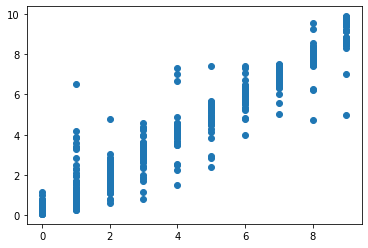

In [35]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]<10):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)

In [36]:
shuffled = df_reg2.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [37]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

137994
137994
        n      k   av.length     std.dev      m     y
0   160.0  141.0  661.843750  164.587997   40.0  4510
1   160.0  133.0  652.887512  156.741806   80.0  4510
2   180.0   47.0   74.566666   14.512603   20.0  4510
3   120.0   93.0   99.625000   48.803493   60.0  4510
4    80.0   68.0  200.149994   63.368740    8.0  2080
5   198.0  173.0  507.494965  164.243591   72.0  4510
6   140.0   98.0  110.692856   49.170376   70.0  4510
7   198.0  166.0  490.202026  171.781097   22.0  4510
8   200.0  179.0  821.250000  195.515594   50.0  4510
9   126.0  107.0  501.873016  128.004990   21.0  4510
10  180.0  160.0  720.972229  179.274765   72.0   869
11  180.0  154.0  706.877808  175.294418   90.0  4510
12  198.0  170.0  780.969727  192.608124   66.0  4510
13  176.0  151.0  445.829559  143.072861   16.0  4510
14  160.0   70.0   98.637497   19.488903   16.0  4510
15  220.0   76.0   98.354546   19.407944   20.0  4510
16  198.0   50.0   75.121216   14.825057   18.0  4510
17  180.0  155

In [38]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(16, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(16, activation = 'relu'))

    model.add(Dense(4, activation = 'relu'))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [40]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=60, batch_size=128, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


895/895 [==============================] - 3s 2ms/step - loss: 171691.3906
Epoch 2/60
895/895 [==============================] - 2s 2ms/step - loss: 69124.2500
Epoch 3/60
895/895 [==============================] - 2s 2ms/step - loss: 50453.1406
Epoch 4/60
895/895 [==============================] - 2s 2ms/step - loss: 42589.9766
Epoch 5/60
895/895 [==============================] - 2s 2ms/step - loss: 35827.5078
Epoch 6/60
895/895 [==============================] - 2s 2ms/step - loss: 30069.3750
Epoch 7/60
895/895 [==============================] - 2s 2ms/step - loss: 25128.5000
Epoch 8/60
895/895 [==============================] - 2s 2ms/step - loss: 23036.4023
Epoch 9/60
895/895 [==============================] - 2s 2ms/step - loss: 21505.5000
Epoch 10/60
895/895 [==============================] - 2s 2ms/step - loss: 20729.3086
Epoch 11/60
895/895 [==============================] - 2s 2ms/step - loss: 19235.7578
Epoch 12/60
895/895 [==============================] - 2s 2ms/step - loss

In [41]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

184/184 [==============================] - 0s 1ms/step
r_square score:  0.9873045742612685
RMSE:


132.39039982408522

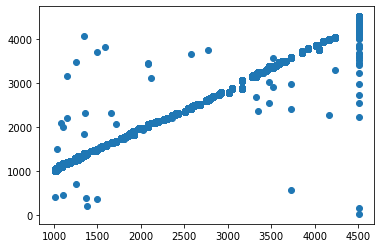

In [42]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)